In [296]:
from pathlib import Path
import xarray as xr
from sklearn_som.som import SOM
import numpy as np
import warnings
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date
import matplotlib.colors as colors
import cartopy.crs as ccrs
import matplotlib
import pickle

In [2]:
data = xr.open_dataset(Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\all_v4.nc"))

In [3]:
lats = data.Latitude.values
lons = data.Longitude.values
times = data.time.values
interval = (
    (times > np.datetime64(date(2011,1,1)).astype('datetime64[ns]'))
    & (times < np.datetime64(date(2020,1,1)).astype('datetime64[ns]'))
)
sla = data.sla[interval].values
sst = data.sst[interval].values
wind_speed = data.wind_speed[interval].values
swh = data.swh[interval].values

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    means_sla = np.nanmean(sla, axis=0)
    means_sst = np.nanmean(sst, axis=0)
    means_swh = np.nanmean(swh, axis=0)
    means_wind_speed = np.nanmean(wind_speed, axis=0)
    print("Done with mean")
    stds_sla = np.nanstd(sla, axis=0)
    stds_sst = np.nanstd(sst, axis=0)
    stds_swh = np.nanstd(swh, axis=0)
    stds_wind_speed = np.nanstd(wind_speed, axis=0)
    print("Done with std")

Done with mean
Done with std


In [5]:
del sst
del swh
del wind_speed
del sla
del times
del data

In [35]:
means = means_sla #np.stack([means_sla, means_sst, means_swh, means_wind_speed])
stds = stds_sla #np.stack([stds_sla, stds_sst, stds_swh, stds_wind_speed])

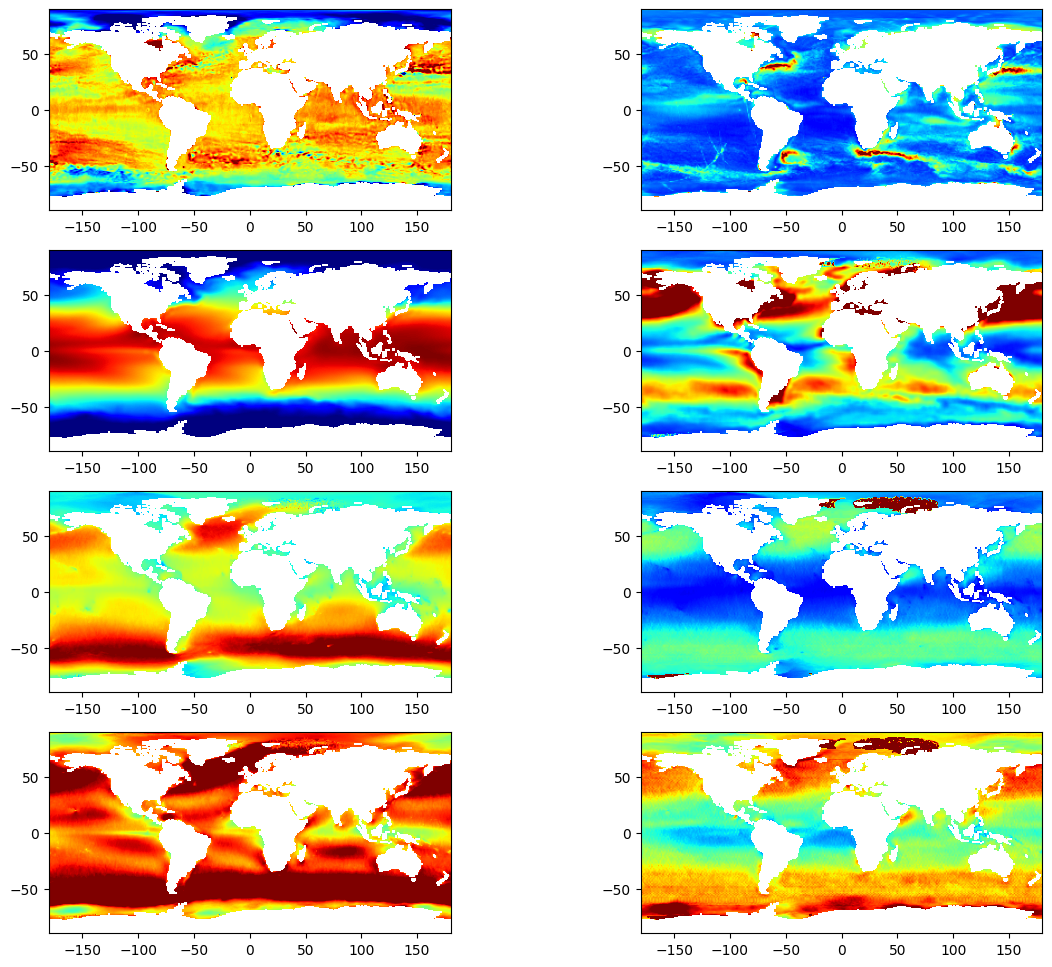

In [7]:
fig, axes = plt.subplots(4,2, figsize=(14,12))
axes[0,0].imshow(means_sla, origin='lower', extent=[-180, 180, -90, 90], vmin=-0.1, vmax=0.1, cmap='jet')
axes[1,0].imshow(means_sst, origin='lower', extent=[-180, 180, -90, 90], vmin=-0.1, vmax=30, cmap='jet')
axes[2,0].imshow(means_swh, origin='lower', extent=[-180, 180, -90, 90], vmin=-1, vmax=4, cmap='jet')
axes[3,0].imshow(means_wind_speed, origin='lower', extent=[-180, 180, -90, 90], vmin=-1, vmax=8, cmap='jet')

axes[0,1].imshow(stds_sla, origin='lower', extent=[-180, 180, -90, 90], vmin=0, vmax=0.3, cmap='jet')
axes[1,1].imshow(stds_sst, origin='lower', extent=[-180, 180, -90, 90], vmin=0, vmax=3, cmap='jet')
axes[2,1].imshow(stds_swh, origin='lower', extent=[-180, 180, -90, 90], vmin=0, vmax=3, cmap='jet')
axes[3,1].imshow(stds_wind_speed, origin='lower', extent=[-180, 180, -90, 90], vmin=0, vmax=5, cmap='jet')

plt.show()

In [43]:
if len(means.shape) == 2:
    nans = np.isnan(means)
    means_no_nan = means[~nans]
    stds_no_nan = stds[~nans]
    lats_no_nan = lats[~nans]
    lons_no_nan = lons[~nans]
    std_mean = np.vstack([stds_no_nan, means_no_nan]).T
    positions = np.vstack([lats_no_nan, lons_no_nan]).T
    #features = np.hstack([std_mean, positions])
    features = std_mean
else:
    nans = np.any(np.isnan(means), axis=0)
    means_no_nan = means[:, ~nans]
    stds_no_nan = stds[:, ~nans]
    lats_no_nan = lats[~nans]
    lons_no_nan = lons[~nans]
    std_mean = np.vstack([stds_no_nan, means_no_nan]).T
    positions = np.vstack([lats_no_nan, lons_no_nan]).T
    #features = np.hstack([std_mean, positions])
    features = std_mean

In [44]:
scaler = preprocessing.StandardScaler().fit(features)
features_scaled = scaler.transform(features)

In [51]:
som = SOM(m=2, n=2, dim=features_scaled.shape[1], max_iter=features_scaled.shape[0]*50) # 8, 5

In [306]:
if som._trained:
    with open("som.pkl", "wb") as f:
        pickle.dump(som, f)
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
else:
    with open("som.pkl", "rb") as f:
        som = pickle.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

In [52]:
som.fit(features_scaled, epochs=10)

In [53]:
classes = np.array([som._find_bmu(x) for x in tqdm(features_scaled)])

100%|██████████| 42880/42880 [00:10<00:00, 3907.59it/s]


In [280]:
color_list = list(colors.cnames)
not_valid_colors = ['white', 'ivory', 'honeydew']
valid_color_list = []
for c in color_list:
    for nv in not_valid_colors:
        if nv in c:
            break
    else:
        valid_color_list.append(c)

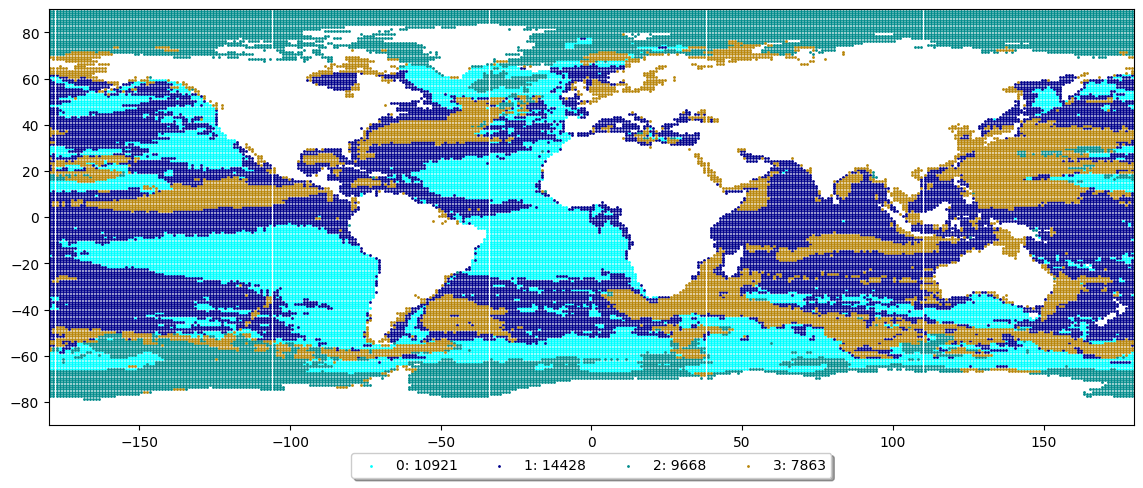

In [55]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
for class_idx, count in zip(*np.unique(classes, return_counts=True)):
    ax.scatter(
        lons_no_nan[classes == class_idx],
        lats_no_nan[classes == class_idx],
        s=1,
        label=f"{class_idx}: {count}",
        c=valid_color_list[class_idx]
    )
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show()

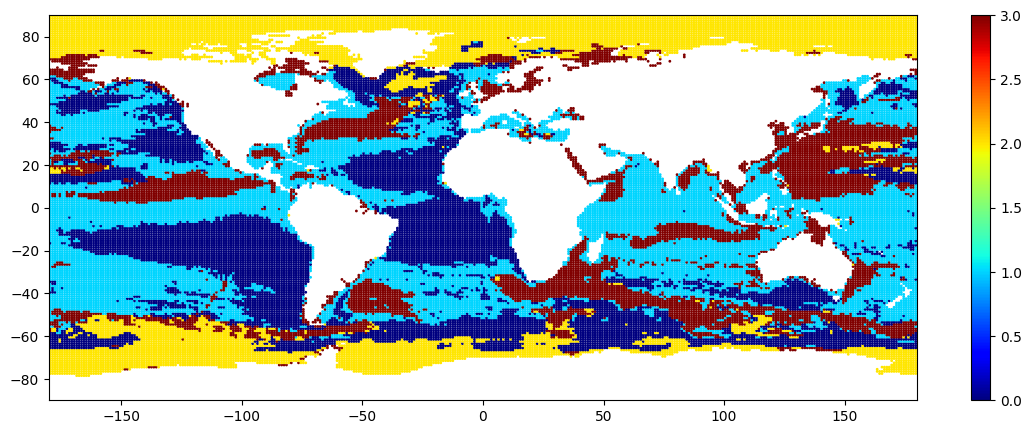

In [56]:
fig, ax = plt.subplots(1,1, figsize=(14,5))
im = ax.scatter(lons_no_nan, lats_no_nan, s=1, c=classes, cmap='jet')
fig.colorbar(im)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
plt.show()

# Image analysis

In [196]:
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
def filter_nan_gaussian_conserving(arr, sigma):
    """
    Apply a gaussian filter to an array with nans.

    Intensity is only shifted between not-nan pixels and is hence conserved.
    The intensity redistribution with respect to each single point
    is done by the weights of available pixels according
    to a gaussian distribution.
    All nans in arr, stay nans in gauss.
    """
    nan_msk = np.isnan(arr)

    loss = np.zeros(arr.shape)
    loss[nan_msk] = 1
    loss = ndimage.gaussian_filter(loss, sigma=sigma, mode='constant', cval=1)

    gauss = arr.copy()
    gauss[nan_msk] = 0
    gauss = ndimage.gaussian_filter(gauss, sigma=sigma, mode='constant', cval=0)
    gauss[nan_msk] = np.nan

    gauss += loss * arr

    return gauss

In [197]:
def smooth_image_classes(image, unique_classes, land_mask):
    out_image = np.empty((len(unique_classes), *image.shape))
    out_image[:] = np.nan
    sigma = 2
    for class_ in sorted(unique_classes):
        mask = image == class_
        filtered_image = filter_nan_gaussian_conserving((mask).astype(np.float64), sigma=sigma)
        out_image[class_] = filtered_image
    output_class_image = np.argmax(out_image, axis=0).astype(np.float64)
    output_class_image[land_mask] = np.nan
    return output_class_image

In [198]:
image = np.empty(means.shape[:2])
image[:] = np.nan
out_image = image.copy().astype(bool)
image[~nans] = classes

In [200]:
unique_classes = np.unique(classes)
output_class_image = smooth_image_classes(image, unique_classes, nans)

In [307]:
image_blobs = np.empty(image.shape)
image_blobs[:] = np.nan
current_class = 0
n_subclasses = []
for class_ in unique_classes:
    image_bool = output_class_image == class_
    image_blob = label(image_bool)
    image_blobs[image_blob != 0] = image_blob[image_blob != 0] + current_class
    current_class += np.max(image_blob)
    n_subclasses.append(np.max(image_blob))
n_subclasses = np.array(n_subclasses)

In [311]:
with open('image_blobs.npy', 'wb') as f:
    np.save(f, image_blobs)
with open('n_subclasses.npy', 'wb') as f:
    np.save(f, n_subclasses)

In [ ]:
with open('n_subclasses.npy', 'rb') as f:
    image_blobs = np.load(f)
with open('n_subclasses.npy', 'rb') as f:
    n_subclasses = np.load(f)

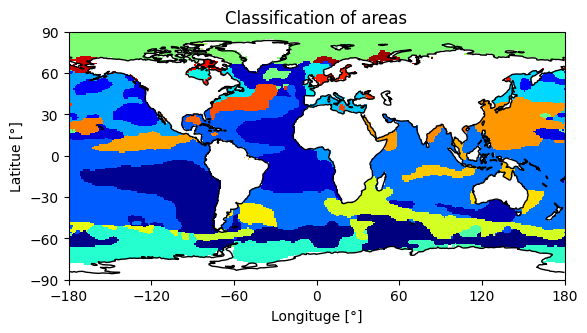

In [245]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
plt.imshow(image_blobs, cmap='jet', origin='lower', interpolation='None', extent=[-180, 180, -90, 90])
plt.xlabel("Longituge [\N{DEGREE SIGN}]")
plt.ylabel("Latitue [\N{DEGREE SIGN}]")
plt.title(f"Classification of areas")
plt.show()

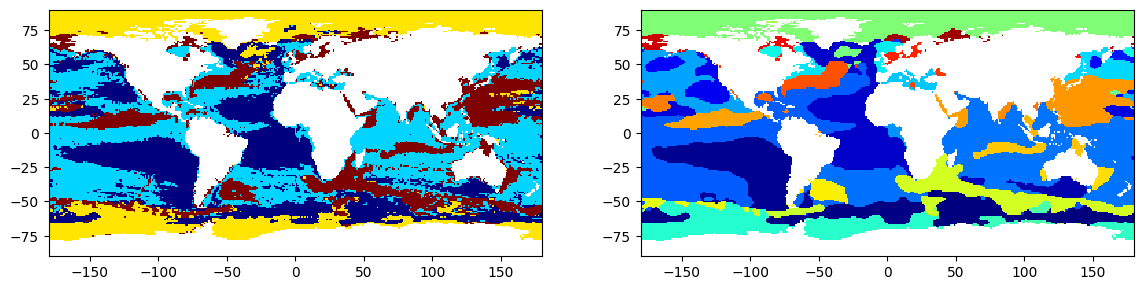

In [243]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].imshow(image, origin='lower', cmap='jet', interpolation='none', extent=[-180, 180, -90, 90])
axes[1].imshow(image_blobs, origin='lower', cmap='jet', interpolation='none', extent=[-180, 180, -90, 90])
plt.show()

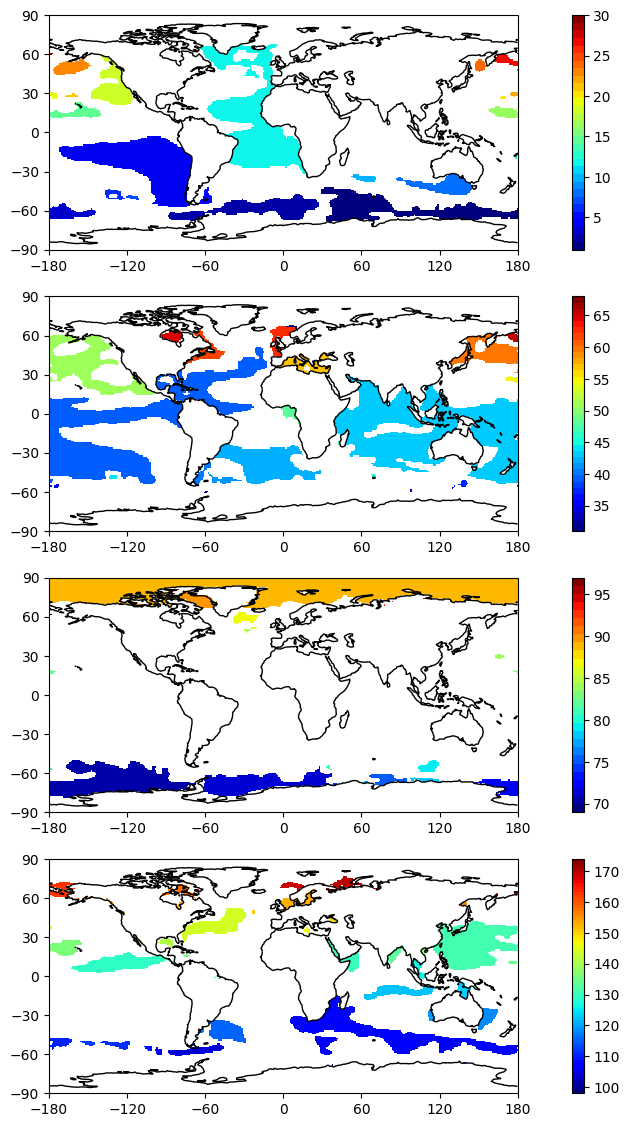

In [295]:
fig, axes = plt.subplots(len(unique_classes),1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(14,14))
for class_id, ax in zip(unique_classes, axes):
    cmap = matplotlib.cm.get_cmap('jet', n_subclasses[class_id])
    image_sub_blobs = image_blobs.copy()
    before = np.sum(n_subclasses[:class_id])
    image_sub_blobs[(image_sub_blobs >= n_subclasses[class_id] + before) | (image_sub_blobs < before)] = np.nan

    ax.coastlines()
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    im = ax.imshow(image_sub_blobs, origin='lower', cmap=cmap, interpolation='none', extent=[-180, 180, -90, 90])
    fig.colorbar(im, ax=ax)
plt.show()

# SOM inference

In [184]:
std_space = np.linspace(0, stds_no_nan.max(), 150)
mean_space = np.linspace(means_no_nan.min(), means_no_nan.max(), 150)
std_space, mean_space = np.meshgrid(std_space, mean_space)
feature_space = np.vstack([std_space.flatten(), mean_space.flatten()]).T
feature_space_scaled = scaler.transform(feature_space)
feature_space_classes = np.array([som._find_bmu(x) for x in tqdm(feature_space_scaled)]).reshape(std_space.shape)

100%|██████████| 22500/22500 [00:02<00:00, 7596.75it/s] 


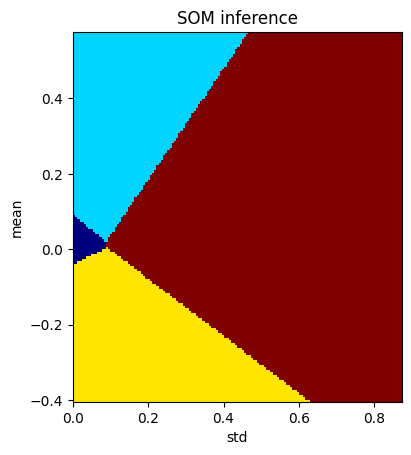

In [187]:
plt.imshow(feature_space_classes, origin='lower', extent = [std_space.min(), std_space.max(), mean_space.min(), mean_space.max()], cmap='jet', interpolation='None')
plt.title("SOM inference")
plt.xlabel('std')
plt.ylabel('mean')
plt.show()